# Spam Detection Using LSTM
In this Demo, we will train deep learning models to classify sms messages as spam or non-spam. We will use the UCI SMS Spam Collection Data Set: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np
import nltk
import string
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


%matplotlib inline

## Loading the Dataset
The SMS Spam Collection is a public set of SMS labeled messages, the target column is either spam or ham.

In [40]:
column_names = ['label', 'body_text']
raw_data = pd.read_csv('./data/SMSSpamCollection.csv', encoding = "ISO-8859-1",sep='\t')
raw_data.columns = column_names
# raw_data = raw_data.sample(frac=1.0)
raw_data.head(n=10)

,label,body_text
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...
5,ham,Even my brother is not like to speak with me. ...
6,ham,As per your request 'Melle Melle (Oru Minnamin...
7,spam,WINNER!! As a valued network customer you have...
8,spam,Had your mobile 11 months or more? U R entitle...
9,ham,I'm gonna be home soon and i don't want to tal...


## Preprocessing
Here, we apply preporcesing steps like tokenizing, stop word removal, lematization and etc.

In [41]:

raw_data['body_text'] = raw_data['body_text'].str.lower()
#remove all charcters that are not whitespace or alphanumeric
raw_data['body_text'] = raw_data['body_text'].str.replace('[^\w\s]','')
#remove numbers
raw_data['body_text'] = raw_data['body_text'].replace('\d', '', regex=True)

raw_data['body_text'] = raw_data['body_text'].apply(lambda x : word_tokenize(x))

stop_words = set(stopwords.words('english')+ list(string.punctuation))
raw_data['body_text'] = raw_data['body_text'].apply(lambda x : [w for w in x if not w in stop_words])

wordnet_lemmatizer = WordNetLemmatizer()
raw_data['body_text'] = raw_data['body_text'].apply(lambda x : [wordnet_lemmatizer.lemmatize(w) for w in x ])

raw_data['body_text'] = raw_data['body_text'].apply(lambda x : ' '.join(x))

/var/folders/8v/lk7x_15d4rz139p6ddryvcvr0000gn/T/ipykernel_48905/3544028164.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_data['body_text'] = raw_data['body_text'].str.replace('[^\w\s]','')


In [42]:
raw_data.head(n=10)

,label,body_text
0,ham,ok lar joking wif u oni
1,spam,free entry wkly comp win fa cup final tkts st ...
2,ham,u dun say early hor u c already say
3,ham,nah dont think go usf life around though
4,spam,freemsg hey darling week word back id like fun...
5,ham,even brother like speak treat like aid patent
6,ham,per request melle melle oru minnaminunginte nu...
7,spam,winner valued network customer selected receiv...
8,spam,mobile month u r entitled update latest colour...
9,ham,im gon na home soon dont want talk stuff anymo...


In [43]:
length_of_the_messages = raw_data['body_text'].str.split(" ")
print("Max number of words = ", length_of_the_messages.str.len().max())


Max number of words =  80


## Preparing Input vectors
Here, we will convert the text data into numerical format. We use keras tokenizer to convert words to integers. Keras tokenizer internally creates a dictionary/vocabulary, the index ordering is based on the frequency of the word (lower integers mean more frequent words). Finally, it replaces each word in the text with its index number from  the vocabulary. Sequences that are shorter than max length specified are padded with zeros.

The labels will be encoded to categorical numbers using LabelEncoder. 


In [44]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import time
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Flatten

le=LabelEncoder()
raw_data['label']=le.fit_transform( raw_data['label'])

x = raw_data['body_text']
y = raw_data['label']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)


max_words=1000
max_len=80

token=Tokenizer(num_words=max_words)
token.fit_on_texts(raw_data['body_text'])

sequences=token.texts_to_sequences(x_train)
sequences_metrix=sequence.pad_sequences(sequences,padding='post',maxlen=max_len)


# process test data
test_sequences = token.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,padding='post',maxlen=max_len)




In [1]:
sequences_metrix[1]

NameError: name 'sequences_metrix' is not defined

## Training the Model
We will train an LSTM model with an embeding layer at the front to convert the integer vectors from the previous section to custom word emebedings for this task. Word embeddings are low-dimensional floating-point vectors (dense vectors) as opposed to sparse vectors obtained from one-hot-encoding. For this example, we will Learn word embeddings from scratch by adding an embeding layer at the begining of our neural network. This layer takes 2D integer tensors of shape (samples, sequence_length). We also have to specify two arguments for the embeding layer: the number of possible tokens and the dimensionality of the embeddings.  

In contrast to other types of neural networks like convolutional neural networks,  RNNs have memory.  This means that every input element is processed independently with no relation to other elements. But, an RNN network keeps information about what it has read so for from a sequence which is very useful in processing text since we need to know the previous words so far to make sense of the text.


In [45]:
model=Sequential()

#embeding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(LSTM(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 

# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) 
model.add(Dense(100,activation='relu',name='hl2')) 
model.add(Dense(1,activation='sigmoid',name='ol'))
    
# loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=3)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 50)            50000     
                                                                 
 lstm_2 (LSTM)               (None, 80, 100)           60400     
                                                                 
 flatten_2 (Flatten)         (None, 8000)              0         
                                                                 
 hl1 (Dense)                 (None, 200)               1600200   
                                                                 
 hl2 (Dense)                 (None, 100)               20100     
                                                                 
 ol (Dense)                  (None, 1)                 101       
                                                                 
Total params: 1,730,801
Trainable params: 1,730,801
No

In [46]:
# Train model
history=model.fit(sequences_metrix,y_train,batch_size=150,epochs=20,callbacks=[es],validation_split=0.2,verbose=1)

Epoch 1/20
24/24 [==============================] - 13s 403ms/step - loss: 0.3873 - accuracy: 0.8611 - val_loss: 0.2831 - val_accuracy: 0.8655
Epoch 2/20
24/24 [==============================] - 10s 425ms/step - loss: 0.1491 - accuracy: 0.9377 - val_loss: 0.0733 - val_accuracy: 0.9809
Epoch 3/20
24/24 [==============================] - 8s 343ms/step - loss: 0.0588 - accuracy: 0.9823 - val_loss: 0.0584 - val_accuracy: 0.9821
Epoch 4/20
24/24 [==============================] - 9s 390ms/step - loss: 0.0391 - accuracy: 0.9865 - val_loss: 0.0517 - val_accuracy: 0.9821
Epoch 5/20
24/24 [==============================] - 8s 314ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0869 - val_accuracy: 0.9821
Epoch 6/20
24/24 [==============================] - 9s 364ms/step - loss: 0.0200 - accuracy: 0.9919 - val_loss: 0.0702 - val_accuracy: 0.9821
Epoch 7/20
24/24 [==============================] - 8s 322ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0492 - val_accuracy: 0.9843
Epoc

## Evaluation

In [56]:
# evaluate model
train_acc=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate

35/35 [==============================] - 1s 26ms/step - loss: 0.1411 - accuracy: 0.9731


In [53]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc[0],train_acc[1])) # train dataset Loss and Accurancy

Loss:0.013 and Accuracy:0.997


In [54]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc[0],test_acc[1])) # test dataset Loss and Accurancy

Loss:0.141 and Accuracy:0.973


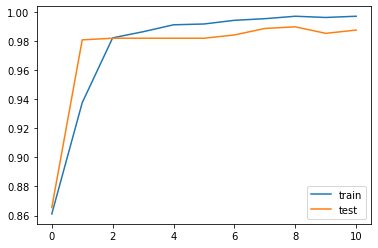

In [55]:
# plot convergence curve 
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()